In [1]:
# Установка библиотек
!pip install -q transformers accelerate bitsandbytes datasets langchain langgraph sentence-transformers faiss-cpu bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 32.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 86.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 40.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB

In [2]:

# ВАЖНО: сначала импортируем torch
import torch
# print(f"Torch version: {torch.__version__}")

# Затем остальные импорты
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss
from tqdm import tqdm
import numpy as np
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage

2025-12-12 13:05:45.250512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765544745.431758      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765544745.490003      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:

# ========== Конфигурация модели DeepSeek 7B ==========
model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
def load_deepseek_model():
    """Загрузка Модели с 4-bit квантизацией для Kaggle"""
    
    # Конфигурация 4-bit квантизации для экономии памяти
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    
    tokenizer = AutoTokenizer.from_pretrained(
        model_id, 
        trust_remote_code=True
    )
    
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.bfloat16
    )
    
    return model, tokenizer

# ========== Загрузка MS MARCO датасета ==========
def load_ms_marco_dataset(num_samples=10000):
    """Загрузка MS MARCO passages для RAG"""
    dataset = load_dataset(
        "microsoft/ms_marco", 
        "v1.1",
        split=f"train[:{num_samples}]"
    )
    
    # Извлечение текстов из passages
    passages = []
    for item in dataset:
        if 'passages' in item and item['passages']:
            for passage in item['passages']['passage_text']:
                if passage and len(passage) > 50:  # Фильтрация коротких текстов
                    passages.append(passage)
    
    return passages[:5000]  # Ограничение для Kaggle

# ========== Создание векторного индекса ==========
def create_vector_store(passages):
    """Создание FAISS индекса с embeddings"""
    embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    print(f"Создание embeddings для {len(passages)} документов...")
    embeddings = embedding_model.encode(
        passages, 
        show_progress_bar=True,
        batch_size=32
    )
    
    # Создание FAISS индекса
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings.astype('float32'))
    
    return index, embedding_model, passages

# ========== Определение состояния графа ==========
class GraphState(TypedDict):
    """Состояние для LangGraph"""
    query: str
    context: list[str]
    answer: str
    retrieved: bool

# ========== Узлы графа ==========
def retrieve_documents(state: GraphState, index, embedding_model, passages, k=3):
    """Узел: поиск релевантных документов"""
    query = state["query"]
    
    # Получение embedding запроса
    query_embedding = embedding_model.encode([query])
    
    # Поиск ближайших документов
    distances, indices = index.search(query_embedding.astype('float32'), k)
    
    # Извлечение контекста
    context = [passages[idx] for idx in indices[0]]
    
    return {
        **state,
        "context": context,
        "retrieved": True
    }

def generate_answer(state: GraphState, model, tokenizer):
    """Узел: генерация ответа с использованием DeepSeek"""
    query = state["query"]
    context = state["context"]
    
    # Формирование промпта с контекстом
    context_text = "\n\n".join([f"Документ {i+1}: {doc}" for i, doc in enumerate(context)])
    
    prompt = f"""### Context:
{context_text}

### Question:
{query}

### Instruction:
Using ONLY the provided context, give a precise and informative answer to the question. If the context does not contain enough information, say so directly.

### Answer:"""
    
    # Генерация ответа
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            pad_token_id=tokenizer.pad_token_id,
        )
    
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Извлечение только ответа (после промпта)
    answer = answer.split("### Answer:")[-1].strip()
    if '</think>' in answer:
        answer = answer.split('</think>')[-1].strip()
    
    return {
        **state,
        "answer": answer
    }

def generate_answer_no_rag(query, model, tokenizer):
    """Генерация ответа БЕЗ контекста (baseline модель)"""
    prompt = f"""### Question:
{query}

### Instruction:
Answer the question based on your knowledge.

### Answer:"""
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2
        )
    
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.split("### Answer:")[-1].strip()


In [4]:

# ========== Создание LangGraph workflow ==========
def create_rag_graph(model, tokenizer, index, embedding_model, passages):
    """Создание графа RAG с LangGraph"""
    
    # Создание графа
    workflow = StateGraph(GraphState)
    
    # Добавление узлов
    workflow.add_node(
        "retrieve", 
        lambda state: retrieve_documents(state, index, embedding_model, passages)
    )
    workflow.add_node(
        "generate", 
        lambda state: generate_answer(state, model, tokenizer)
    )
    
    # Определение рёбер
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "generate")
    workflow.add_edge("generate", END)
    
    # Компиляция графа
    app = workflow.compile()
    
    return app


In [5]:

# ========== Основной pipeline ==========
def main():
    global rag_app
    global model
    global tokenizer
    
    print(f"🚀 Загрузка модели {model_id}...")
    model, tokenizer = load_deepseek_model()
    
    print("\n📚 Загрузка MS MARCO датасета...")
    passages = load_ms_marco_dataset(num_samples=5000)
    print(f"Загружено {len(passages)} документов")
    
    print("\n🔍 Создание векторного индекса...")
    index, embedding_model, passages = create_vector_store(passages)
    
    print("\n🔧 Создание LangGraph RAG pipeline...")
    rag_app = create_rag_graph(model, tokenizer, index, embedding_model, passages)
    
    # ========== Тестирование ==========
    test_queries = [
        "What is machine learning?",
        "How does natural language processing work?",
        "Explain deep learning architectures"
    ]
    
    print("\n" + "="*60)
    print("💬 ТЕСТИРОВАНИЕ RAG СИСТЕМЫ")
    print("="*60)
    
    for query in test_queries:
        print(f"\n🔵 Вопрос: {query}")
        print("-" * 60)
        
        # Запуск RAG pipeline
        result = rag_app.invoke({
            "query": query,
            "context": [],
            "answer": "",
            "retrieved": False
        })
        
        print(f"📄 Найдено документов: {len(result['context'])}")
        print(f"\n✅ Ответ:\n{result['answer']}")
        print("=" * 60)

# Запуск
if __name__ == "__main__":
    main()


🚀 Загрузка модели deepseek-ai/DeepSeek-R1-Distill-Qwen-7B...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/6.62G [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]


📚 Загрузка MS MARCO датасета...


README.md: 0.00B [00:00, ?B/s]

v1.1/validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

v1.1/train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

v1.1/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Загружено 5000 документов

🔍 Создание векторного индекса...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Создание embeddings для 5000 документов...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]


🔧 Создание LangGraph RAG pipeline...

💬 ТЕСТИРОВАНИЕ RAG СИСТЕМЫ

🔵 Вопрос: What is machine learning?
------------------------------------------------------------
📄 Найдено документов: 3

✅ Ответ:
Machine learning is a field that studies how computers can improve their performance on a task through experience, using data and statistics to identify patterns and make predictions or decisions without being explicitly programmed to do so. It involves creating algorithms that can learn from data, make decisions, and adapt to new data over time. Machine learning is closely related to fields like artificial intelligence and big data, and it is often used in applications where traditional programming approaches would be too time-consuming or impractical.

🔵 Вопрос: How does natural language processing work?
------------------------------------------------------------
📄 Найдено документов: 3

✅ Ответ:
The context provided does not contain information about how natural language processing (NLP)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from bert_score import score

def compute_bertscore(invoker, dataset, sample_size=100):
    predictions = []
    references = []
    indices = np.random.choice(len(dataset), min(sample_size, len(dataset)), replace=False)
    with torch.no_grad():
        for idx in tqdm(indices):
            item = dataset[int(idx)]
            prompt = item['query']
            if (len(item['answers'])) == 0: continue
            reference = item['answers'][0]
            if not reference:
                continue
            prediction = invoker(prompt)
            if prediction:
                predictions.append(prediction)
                references.append(reference)
    if predictions:
        P, R, F1 = score(predictions, references, lang="en", verbose=False)
        return {
            'precision': P.mean().item(),
            'recall': R.mean().item(),
            'f1': F1.mean().item()
        }
    return {'precision': 0, 'recall': 0, 'f1': 0}

def plot_training_and_bertscore(bertscore_dicts, savepath='training_results.png'):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))

    # Второй график ― столбцы по BERTScore
    models = [d['model'] for d in bertscore_dicts]
    precisions = [d['precision'] for d in bertscore_dicts]
    recalls = [d['recall'] for d in bertscore_dicts]
    f1s = [d['f1'] for d in bertscore_dicts]

    x = np.arange(len(models))
    width = 0.25

    axes.bar(x - width, precisions, width, label='Precision')
    axes.bar(x,        recalls,   width, label='Recall')
    axes.bar(x + width, f1s,      width, label='F1')
    axes.set_ylabel('Score')
    axes.set_title('BERTScore по моделям')
    axes.set_xticks(x)
    axes.set_xticklabels(models)
    axes.legend()
    axes.set_ylim(0.7, 1.0)

    # Значения на столбцах
    for i, (p, r, f) in enumerate(zip(precisions, recalls, f1s)):
        axes.text(i-width, p+0.01, f'{p:.3f}', ha='center', va='bottom', fontsize=9)
        axes.text(i,       r+0.01, f'{r:.3f}', ha='center', va='bottom', fontsize=9)
        axes.text(i+width, f+0.01, f'{f:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Графики сохранены в '{savepath}'")
    plt.show()

def no_rag_invoker(model, tokenizer):
    def invoker(prompt):
        model.eval()
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            pad_token_id=tokenizer.pad_token_id,
        )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text[len(prompt):].strip()
    return invoker

def rag_invoker(app):
    def invoker(prompt):
        return rag_app.invoke({
            "query": prompt,
            "context": [],
            "answer": "",
            "retrieved": False
        })['answer']
    return invoker

In [8]:
val_data

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 10047
})

In [23]:
rag_score = compute_bertscore(rag_invoker(rag_app), val_data, 10)

100%|██████████| 10/10 [03:11<00:00, 19.14s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
rag_score

{'precision': 0.8402791023254395,
 'recall': 0.8419493436813354,
 'f1': 0.8407195806503296}

In [25]:
no_rag_score = compute_bertscore(no_rag_invoker(model, tokenizer), val_data, 10)

100%|██████████| 10/10 [00:48<00:00,  4.80s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Графики сохранены в 'training_results.png'


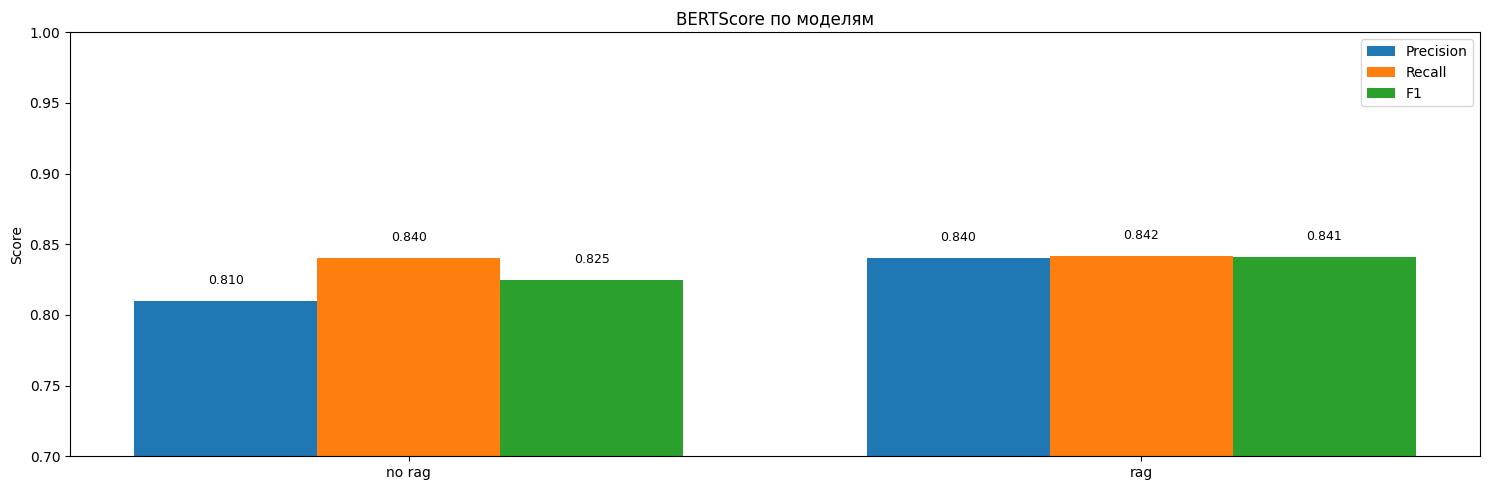

In [26]:
stats = [
    {"model": "no rag", **no_rag_score},
    {"model": "rag", **rag_score}
]

plot_training_and_bertscore(stats)

In [18]:
# Генерация ответа
prompt = """### Context:
zero context

### Question:
what are the long term effects of not eating breakfast

### Instruction:
Using the provided context, give a precise and informative answer to the question. If the context does not contain enough information, say so directly.

### Answer:"""
inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        pad_token_id=tokenizer.pad_token_id,
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Context:
zero context

### Question:
what are the long term effects of not eating breakfast

### Instruction:
Using the provided context, give a precise and informative answer to the question. If the context does not contain enough information, say so directly.

### Answer: 

The question is about the long-term effects of not eating breakfast. Based on the provided context, there is no specific information given about this topic. The context only mentions the short-term effects of not eating breakfast, such as feeling tired, having low energy, and impacting concentration. However, it does not provide any details about the long-term consequences. Therefore, the answer cannot be accurately determined from the given information.
</think>

The question asks about the long-term effects of not eating breakfast. The provided context discusses the short-term effects, such as feeling tired, low energy, and impacting concentration. However, it does not provide any information about the long-